In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10, 8)
from keras import optimizers
import tensorflow as tf
from keras.optimizers.legacy import Adam, Nadam
from keras.layers import Dense, LSTM, Flatten, Activation, Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.metrics import RootMeanSquaredError
from keras.layers import Input
#from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings("ignore")
import datetime


2023-09-12 19:44:51.863205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 19:44:51.936465: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 19:44:51.937942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 19:44:53.097129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os 
import sys

!pwd
!ls


/home/duvrdx/Documents/dataset
dataset.csv	dataset_v2.ipynb       parse_tocsv.py	 timeseries.ipynb
dataset.ipynb	files		       regression.ipynb
dataset_v2.csv	NAS_Dissertacao.ipynb  requirements.txt


In [3]:

class NAS:
    ''' Exploracão de Arquitectura de redes neurais utilizando o conceito
    de Neural Architeture Search - NAS https://www.jmlr.org/papers/volume20/18-598/18-598.pdf '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.optimizers = ['SGD', 'RMSprop', 'Adam','Adadelta','Adamax']
        self.qtde_camada = [10, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]
        self.tamanho_camada = [32, 64, 128, 256, 512]
        # self.loss = ['mse','mae','map'] # Vou optar por loss = MSE
        self.activation = ['identity', 'logistic', 'relu', 'tanh'] #,'softmax',]
        # self.metricas = ['rmse','mse','mae'] # Vou setar a métrica do algoritmo igual a do artigo

        # Exclusivos Para o modelo MLP Regressor sklearn
        self.hidden_layer = [10, 20, 30, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
        self.alpha = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]
        self.batch_size = [200, 250, 300] #[50, 100, 150, 200, 250, 300]
        self.learning_rate = [0.1, 0.001, 0.0001, 0.00001, 0.000001, 0.000001]
        self.max_iter = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

    def normaliza_reduz_treino_teste(self):
        '''
        Normalização - Processo no qual da amostra(x) é descontada a média(u) e
        dividido pelo desvio padrão(s), de uma forma que a nova amostra(z) esteja
        em um intervalo de 0 a 1.
        Análise de Componentes Principais - Técnica de estatística multivariada que
        transforma o conjunto de variáveis em
        um subconjunto de variáveis, mantendo as dimensões do original, esse subconjunto
        são os componentes principais. Cada componente é uma combinação linear das variáveis,
        mantendo independência entre si e estimados com o objetivo de reter o máximo de
        informação, em relação a variação contida no conjunto original \citep{Hongyu2016}.
        :df: DataFrame a ser reduzido
        :return: Base completa transformada pelo PCA e normalizada
        '''
        pca = PCA(0.98)
        scaler = StandardScaler()
        self.X_normalizado_reduzido = pd.DataFrame(pca.fit_transform(scaler.fit_transform(self.X)))
        # Base de treino e teste
        self.X_train, self.X_test, \
        self.y_train, self.y_test = train_test_split(self.X_normalizado_reduzido,
                                                     self.y,
                                                    random_state=42)
        return self

    def search_space_keras(self, qtde_arquiteturas):
        ''' Defines which architectures can be represented in principle
        qtde_arquiteturas: Número de Arquiteturas a serem exploradas
        return: Uma lista de parametros a serem utilizados para construção de Redes Neurais'''
        self.activation = ['sigmoid', 'relu', 'selu','elu' ,'tanh',
                           'softmax', 'softplus', 'softsign', 'exponential']
        topografias = []
        for _ in range(qtde_arquiteturas):
            parametro = []
            # Quantidade de camadas
            qtde_camadas = np.random.choice(self.qtde_camada)
            parametro.append(qtde_camadas)
            for _ in range(qtde_camadas):
                # Tamanho de cada camada
                parametro.append(np.random.choice(self.tamanho_camada))
            # # Loss Function
            # parametro.append(np.random.choice(self.loss))
            # Activation Function
            parametro.append(np.random.choice(self.activation))
            # # Métrica de Avaliacao
            # parametro.append(np.random.choice(self.metricas))
            # Otimizador
            parametro.append(np.random.choice(self.optimizers))
            topografias.append(parametro)
        return topografias

    def search_space_sklearn(self, qtde_arquiteturas):
        ''' Defines which architectures can be represented in principle
        qtde_arquiteturas: Número de Arquiteturas a serem exploradas
        return: Uma lista de parametros a serem utilizados para construção de Redes Neurais'''
        topografias = []
        for _ in range(qtde_arquiteturas):
            parametro = []
            # Quantidade de camadas ocultas
            parametro.append(np.random.choice(self.hidden_layer))
            # Função de ativação utilizada
            parametro.append(np.random.choice(self.activation))
            # Termo de regularização L2 - Alpha
            parametro.append(np.random.choice(self.alpha))
            # Tamanho dos lotes de treinamento
            parametro.append(np.random.choice(self.batch_size))
            # Taxa de aprendizado
            parametro.append(np.random.choice(self.learning_rate))
            # Número máximo de iteraçoes
            parametro.append(np.random.choice(self.max_iter))
            topografias.append(parametro)
        return topografias

    def search_strategy_mlp_skl(self, aval, epochs):
        ''' Details how to explore the search space

        Elsken et al. (2017) propose a simple yet well performing hill climbing
        algorithm that discovers high-quality architectures by greedily moving in the
        direction of better performing architectures without requiring more sophisticated
        exploration mechanisms.

        Estratégia escolhida por enquanto: Hill Climbing com critério de Greedy Search

        - Selecionar os parametros mais comuns nas M arquiteturas com melhores resultaods
        e fazer uma nova rodada de avaliaçao por N vezes (epochs)
        '''
        count = 0
        rmse_base = 10000.00
        nova_hl = []
        nova_act = []
        nova_alpha = []
        nova_batch = []
        nova_lr = []
        nova_max = []
        self.melhor_arch = []
        while count < epochs:
            print(f'Epoca: {count+1}')
            for _ in self.search_space_sklearn(aval):
                # print(_)
                rmse = nas_teste.modelo_MLP_skl(_).rmse_mlp
                #if count+1 == 1: rmse_base = rmse
                if rmse < rmse_base:
                    rmse_base = rmse
                    print(_)
                    self.melhor_arch = _
                    print(f'RMSE: {rmse_base:.5f} m^3/t')
                    print(f'R2: {nas_teste.modelo_MLP_skl(_).r2_mlp:.5f} m^3/t')

                    nova_hl.append(_[0])
                    nova_act.append(_[1])
                    nova_alpha.append(_[2])
                    nova_batch.append(_[3])
                    nova_lr.append(_[4])
                    nova_max.append(_[5])
            self.hidden_layer = list(set(nova_hl))
            self.activation = list(set(nova_act))
            self.alpha = list(set(nova_alpha))
            self.batch_size = list(set(nova_batch))
            self.learning_rate = list(set(nova_lr))
            self.max_iter = list(set(nova_max))
            print('-'* 40)
            count+=1
        return self


    def search_strategy_mlp_keras(self, aval, epochs, modelo='LSTM'):
        ''' Details how to explore the search space

        Elsken et al. (2017) propose a simple yet well performing hill climbing
        algorithm that discovers high-quality architectures by greedily moving in the
        direction of better performing architectures without requiring more sophisticated
        exploration mechanisms.

        Estratégia escolhida por enquanto: Hill Climbing com critério de Greedy Search

        - Selecionar os parametros mais comuns nas M arquiteturas com melhores resultaods
        e fazer uma nova rodada de avaliaçao por N vezes (epochs)
        '''
        count = 0
        rmse_base = 1.00
        nova_qtde_camada = []
        nova_tamanho_camada = []
        nova_activation = []
        nova_opt = []
        self.melhor_arch = None
        while count < epochs:
            print(f'Epoca: {count+1}')
            for _ in self.search_space_keras(aval):
              if modelo == 'LSTM':
                  # print(_)
                  rmse = nas_teste.modelo_LSTM_Keras(_).rmse_mlp_lstm
                  r2 = nas_teste.modelo_LSTM_Keras(_).r2_mlp_lstm
                  #if count+1 == 1: rmse_base = rmse
              elif modelo == 'CONV':
                  # print(_)
                  rmse = nas_teste.modelo_Conv_Keras(_).rmse_conv1d
                  r2 = nas_teste.modelo_Conv_Keras(_).r2_mlp_conv1d
                  #if count+1 == 1: rmse_base = rmse
              if rmse < rmse_base:
                  rmse_base = rmse
                  print(_)
                  self.melhor_arch = _
                  print(f'RMSE {modelo}: {rmse_base:.5f} m^3/t')
                  print(f'R2 {modelo}: {rmse_base:.5f} m^3/t')

                  nova_qtde_camada.append(_[0])
                  for i in range(_[0]):
                      nova_tamanho_camada.append(_[i+1])
                  nova_activation.append(_[-2])
                  nova_opt.append(_[-1])
            if len(nova_tamanho_camada) > 0: # Serve pra utilizar as info anteriores caso não tenha ocorrido melhora na época
              self.qtde_camada = list(set(nova_qtde_camada))
              self.tamanho_camada = list(set(nova_tamanho_camada))
              self.activation = list(set(nova_activation))
              self.optimizers = list(set(nova_opt))
            print('-'* 40)
            count+=1
        return self

    def _plot_hist_residuos_e_scatter(y_pred, y):
        ''' Plota gráfico com o histograma de erro 
        e um gráfico de dispersão entre o predito
        e o real '''
        pass
        
            
    def plot_real_vs_pred_with_residuals(self, modelo, y_real, y_pred, residuos):
        ''' Plot real vs predicted values with a residuals histogram '''

        # Criar uma figura com subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Gráfico de Séries Temporais Linear
        axs[0].plot(y_real.index, y_real.values, label='Real')
        axs[0].plot(y_real.index, y_pred, label='Predito')
        axs[0].set_xlabel('Tempo')
        axs[0].set_ylabel('Valores')
        axs[0].set_title(f'Real x Predito - {modelo}')
        axs[0].legend()
        axs[0].grid(True)

        # Histograma de Resíduos
        axs[1].hist(residuos, bins=50, color='skyblue', edgecolor='black')
        axs[1].set_title(f'Histograma de Resíduos - {modelo}')
        axs[1].set_xlabel('Frequência')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    def performance_estimation_strategy(self, aval, epochs, modelo=None):
        ''' Find architectures that achieve high predictive performance on unseen data '''
        if modelo == None:
            self.arch_usada = self.search_strategy_mlp_skl(aval, epochs).melhor_arch
            print('\n')
            self.modelo = self.modelo_MLP_skl(self.arch_usada, True)
            print(f'Melhor Arquitetura: {self.arch_usada}')
            print(f'RMSE MLP p/ toda a base: {self.modelo.rmse_mlp_X:.5f} m^3/t')
            print(f'R2 MLP p/ toda a base: {self.modelo.r2_mlp_X:.5f}')

            erro = self.modelo.prediction_mlp_skl_X - self.y.values

            # Chame a função para plotar o gráfico
            self.plot_real_vs_pred_with_residuals('MLP', self.y, self.modelo.prediction_mlp_skl_X, erro)

        elif modelo == 'LSTM':
            self.arch_usada = self.search_strategy_mlp_keras(aval, epochs).melhor_arch
            print('\n')
            self.modelo = self.modelo_LSTM_Keras(self.arch_usada, True)
            print(f'Melhor Arquitetura: {self.arch_usada}')
            print(f'RMSE LSTM p/ toda a base: {self.modelo.rmse_mlp_lstm_X:.5f} m^3/t')
            print(f'R2 LSTM p/ toda a base: {self.modelo.r2_lstm_X:.5f}')

            predicao_lstm = []
            for result in self.modelo.prediction_lstm_X:
                #print(result)
                predicao_lstm.append(result[0][0])
            erro = predicao_lstm - self.y.values

            # Chame a função para plotar o gráfico
            self.plot_real_vs_pred_with_residuals('LSTM', self.y, predicao_lstm, erro)

        elif modelo == 'CONV':
            self.arch_usada = self.search_strategy_mlp_keras(aval, epochs, modelo=modelo).melhor_arch
            print('\n')
            self.modelo = self.modelo_Conv_Keras(self.arch_usada, True)
            print(f'Melhor Arquitetura: {self.arch_usada}')
            print(f'RMSE CONV p/ toda a base: {self.modelo.rmse_conv1d_X:.5f} m^3/t')
            print(f'R2 CONV p/ toda a base: {self.modelo.r2_conv1d_X:.5f}')

            predicao_conv1d = []
            for result in self.modelo.prediction_conv1d_X:
                predicao_conv1d.append(result[0])
            erro = predicao_conv1d - self.y.values

            # Chame a função para plotar o gráfico
            self.plot_real_vs_pred_with_residuals('Conv', self.y, predicao_conv1d, erro)

        return self
            


    def modelo_MLP_Keras(self, params, all_df=False):
        '''
        Roda um Modelo MLP para ser explorado pelo NAS
        :return: Modelo MLP Nao funciona nem perto do SKLearn
        '''
        # self.model = Sequential()
        # self.model.add(Flatten(input_shape=(self.X_train.shape[1:])))
        # for i in range(params[0]):
        #     self.model.add(Dense(params[i+1], activation=params[-2]))
        # # self.model.add(Activation(params[-2]))
        # self.model.add(Dense(1))
        # self.model.compile(loss='mean_squared_error',
        #               optimizer=params[-1],
        #               metrics=[RootMeanSquaredError()])
        # self.model.fit(self.X_train, self.y_train.values, verbose=0)
        # if all_df:
        #   self.prediction_mlp_keras = self.model.predict(self.X_test)
        #   self.mse_mlp_keras = (np.square(self.y_test.values - self.prediction_mlp_keras)).mean(axis=None)
        #   self.rmse_mlp_keras = np.sqrt(self.mse_mlp_keras)
        # else:
        #   self.prediction_mlp_keras = self.model.predict(self.X_test)
        #   self.mse_mlp_keras = (np.square(self.y_test.values - self.prediction_mlp_keras)).mean(axis=None)
        #   self.rmse_mlp_keras = np.sqrt(self.mse_mlp_keras)
        #   return self

    def modelo_LSTM_Keras(self, params, all_df = False):
        '''
        Roda um Modelo LSTM para ser explorado pelo NAS
        :return: Modelo LSTM
        '''
        X_train_lstm = self.X_train[0].values.reshape((self.X_train.shape[0],
                                                    1, 1))
        X_test_lstm = self.X_test[0].values.reshape((self.X_test.shape[0],
                                                  1, 1))        
        X_lstm = self.X_normalizado_reduzido[0].values.reshape((self.X_normalizado_reduzido.shape[0],
                                                  1, 1))
        self.model = Sequential()
        self.model.add(LSTM(params[0],
                            activation=params[-2], 
                            input_shape=(X_train_lstm.shape[1:]),
                            return_sequences=True))
        # for i in range(params[0]):
        #     self.model.add(Dense(params[i+1], activation=params[-2]))
        # self.model.add(Activation(params[-2]))
        optimizer = Adam(learning_rate=0.001, decay=0.001/10)
        self.model.add(Dense(1)) 
        self.model.compile(loss='mean_squared_error', 
                           optimizer=optimizer,
                           metrics=[RootMeanSquaredError()])
        self.model.fit(X_train_lstm, self.y_train.values, verbose=0)
        if all_df:
            self.prediction_lstm_X = self.model.predict(X_lstm)
            self.mse_mlp_lstm_X = (np.square(self.y.values - self.prediction_lstm_X)).mean(axis=None)
            self.rmse_mlp_lstm_X = np.sqrt(self.mse_mlp_lstm_X)
            
            # Calcular o R² para o conjunto de dados completo
            self.r2_lstm_X = r2_score(self.y.values, self.prediction_lstm_X)
        
        else:
            self.prediction_lstm = self.model.predict(X_test_lstm)
            self.mse_mlp_lstm = (np.square(self.y_test.values - self.prediction_lstm)).mean(axis=None)
            self.rmse_mlp_lstm = np.sqrt(self.mse_mlp_lstm)
            
            # Calcular o R² para o conjunto de teste
            self.r2_lstm = r2_score(self.y_test.values, self.prediction_lstm)
    
        return self

    def modelo_MLP_skl(self, params, all_df=False):
        '''
        Roda um Modelo MLP para o GA do DEAP
        :return: Modelo MLP
        '''
        self.mlp = MLPRegressor(hidden_layer_sizes=(params[0],),
                       activation=params[1],
                       solver='adam',
                       alpha=params[2],
                       batch_size=params[3],
                       learning_rate_init=params[4],
                       max_iter=params[5])
        self.mlp.fit(self.X_train, self.y_train.values)
        if all_df:
            self.prediction_mlp_skl_X = self.mlp.predict(self.X_normalizado_reduzido)
            self.mse_mlp_X = (np.square(self.y.values - self.prediction_mlp_skl_X)).mean(axis=None)
            self.rmse_mlp_X = np.sqrt(self.mse_mlp_X)
            
            # Calcular o R² para o conjunto de dados completo
            self.r2_mlp_X = r2_score(self.y.values, self.prediction_mlp_skl_X)
        
        else:
            self.prediction_mlp_skl = self.mlp.predict(self.X_test)
            self.mse_mlp = (np.square(self.y_test.values - self.prediction_mlp_skl)).mean(axis=None)
            self.rmse_mlp = np.sqrt(self.mse_mlp)
            
            # Calcular o R² para o conjunto de teste
            self.r2_mlp = r2_score(self.y_test.values, self.prediction_mlp_skl)
        
        return self

    def modelo_Conv_Keras(self, params, all_df=False):
        '''
        Roda um Modelo Convulotional para ser explorado pelo NAS
        :return: Modelo Convulotional
        '''
        X_train_conv1d = self.X_train.values.reshape((self.X_train.shape[0],
                                                    self.X_train.shape[1], 1))
        X_test_conv1d = self.X_test.values.reshape((self.X_test.shape[0],
                                                  self.X_test.shape[1], 1))
        X_conv1d = self.X_normalizado_reduzido.values.reshape((self.X_normalizado_reduzido.shape[0],
                                                  self.X_normalizado_reduzido.shape[1], 1))        
                
        self.model = Sequential()
        self.model.add(Conv1D(filters=params[0], kernel_size=2, activation=params[-2], input_shape=(self.X_train.shape[1],
                                                                                             1)))
        self.model.add(MaxPooling1D(pool_size=2))
        self.model.add(Flatten())
        #for i in range(params[0]):
            #self.model.add(Dense(params[i+1], activation=params[-2]))
        # self.model.add(Activation(params[-2]))
        self.model.add(Dense(1))
        self.model.compile(loss='mean_squared_error',
                           optimizer=params[-1],
                           metrics=[RootMeanSquaredError()])
        self.model.fit(X_train_conv1d, self.y_train.values, verbose=0)
        if all_df:
            self.prediction_conv1d_X = self.model.predict(X_conv1d)
            self.mse_conv1d_X = (np.square(self.y.values - self.prediction_conv1d_X)).mean(axis=None)
            self.rmse_conv1d_X = np.sqrt(self.mse_conv1d_X)
            
            # Calcular o R² para o conjunto de dados completo
            self.r2_conv1d_X = r2_score(self.y.values, self.prediction_conv1d_X)
            
        else:
            self.prediction_conv1d = self.model.predict(X_test_conv1d)
            self.mse_conv1d = (np.square(self.y_test.values - self.prediction_conv1d)).mean(axis=None)
            self.rmse_conv1d = np.sqrt(self.mse_conv1d)
            
            # Calcular o R² para o conjunto de teste
            self.r2_conv1d = r2_score(self.y_test.values, self.prediction_conv1d)
        
        return self


    

In [4]:
def series_to_supervised(df, n_out=1, dropnan=True):
    '''
    Do algoritmo de experimento de seleção de caracterisitcas.py
    :param n_in: Número de observaçoes defasadas(lag) do input
    :param n_out: Número de observaçoes defasadas(lag) do output
    :param dropnan:
    :return: Dataframe adequado para supervised learning
    '''
    df_sup = df
    for col in df_sup.columns:
        for j in range(0, n_out):
            col_name_2 = str(col+f'_(t-{j})')
            df_sup[col_name_2] = df_sup[col].shift(-j)
        df_sup = df_sup.drop(col, axis=1)
    if dropnan:
        df_sup = df_sup.dropna() # data cleaning
    return df_sup


In [5]:
if __name__ == "__main__":
    random.seed(42)
    # Base de Dados Crua
    df = pd.read_csv("dataset_v2.csv", index_col=0).dropna()
    df['data_hora'] = pd.to_datetime(df['data_hora'])
    df.set_index('data_hora', inplace=True)
    df.sort_index(inplace=True)

    print(df.info())

    # Base de Dados adaptada para um problema de aprendizado supervisionado
    df_sup = series_to_supervised(df, 6) # 6 Periodos de 4h = 24h
    # print(df_sup.head())

    # Características selecionadas no artigo para dados de entrada
    y = df_sup['ilha_da_luz_(t-0)']
    X = df_sup[['francisco_gross_(t-0)','pacotuba_(t-0)', 'sao_joao_(t-0)']] #, 'data_hora_(t-0)']]

    # print(X.head())
    # print(y.head())

    nas_teste = NAS(X, y)
    nas_teste.normaliza_reduz_treino_teste()
    rodadas = 100
    # ### Testes do SKlearn
    # print('----- Rodando o MLP SkLearn --------')
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_sklearn(rodadas):
    #     #print(_)
    #     rmse = nas_teste.modelo_MLP_skl(_).rmse_mlp
    #     #print(f'RMSE: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {rodadas} rodadas')
    # print('\n')
    # print(f'Menor RMSE SkLearn: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

    # #### Testes do Keras
    # print('\n')
    # print('----- Rodando o MLP keras --------')    
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_keras(rodadas):
    #     #print(_)
    #     rmse = nas_teste.modelo_MLP_Keras(_).rmse_mlp_keras
    #     #print(f'RMSE Modelo MLP Keras: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {rodadas} rodadas')
    # print('\n')
    # print(f'Menor RMSE MLP Keras: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

    ### Testes do LSTM
    # print('\n')
    # print('----- Rodando o LSTM keras --------')    
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_keras(1000):
    #     #print(_)
    #     rmse = nas_teste.modelo_LSTM_Keras(_).rmse_mlp_lstm
    #     #print(f'RMSE Modelo LSTM Keras: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         print(_)
    #         print(f'RMSE Modelo LSTM Keras: {rmse:.2f} m^3/t')
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {5} rodadas')
    # print('\n')
    # print(f'Menor RMSE LSTM Keras: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

    # #### Testes do Conv1d
    # print('\n')
    # print('----- Rodando o Conv1d --------')    
    # referencia = 1.0
    # arquitetura = []
    # start = datetime.datetime.now()
    # print(start)
    # for _ in nas_teste.search_space_keras(rodadas):
    #     #print(_)
    #     rmse = nas_teste.modelo_Conv_Keras(_).rmse_conv1d
    #     print(f'RMSE Modelo Conv1d: {rmse:.2f} m^3/t')
    #     if rmse < referencia:
    #         referencia = rmse
    #         arquitetura = _
    # end = datetime.datetime.now()
    # print(end)
    # print(f'Duração: {end - start} p/ {rodadas} rodadas')
    # print('\n')
    # print(f'Menor RMSE Conv1d: {referencia:.2f} m^3/t')
    # print(f'Com Arquitetura: {arquitetura}')

# Teste das Search Strategies
    aval = 100
    epocas = 5
    # start = datetime.datetime.now()
    # print(start)
    # print('\n')
    # print(' ---- MLP sklearn -----')
    # melhor_arquitetura = nas_teste.search_strategy_mlp_skl(aval, epocas).melhor_arch
    # print(melhor_arquitetura)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')
    # print('-'* 40)
    # print(' ---- LSTM Keras -----')
    # start = datetime.datetime.now()
    # print(start)
    # nas_teste.search_strategy_mlp_keras(5, epocas)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')
    # print('-'* 40)
    # print(' ---- Conv1d Keras -----')
    # start = datetime.datetime.now()
    # print(start)
    # nas_teste.search_strategy_mlp_keras(aval, epocas, modelo='CONV')
    # print('-'* 40)
    # end = datetime.datetime.now()
    # print(end, sep='\n')
    # print('\n')
    # print(f'Duração: {end - start}')

 #### Teste das Performance strategies
    nas_teste.performance_estimation_strategy(aval, epocas)
    print('\n')
    # nas_teste.performance_estimation_strategy(100, epocas, 'CONV')
    # print('\n')
    # nas_teste.performance_estimation_strategy(aval, epocas, 'LSTM')
    # for _ in range(5):
    #   start = datetime.datetime.now()
    #   print(start)
    #   print('\n')
    #   print(' ---- LSTM Keras -----')
    #   # nas_teste.performance_estimation_strategy(100, 5)
    #   nas_teste.performance_estimation_strategy(100, epocas, 'LSTM')
    #   end = datetime.datetime.now()
    #   print(end, sep='\n')
    #   print('\n')
    #   print(f'Duração: {end - start}')
    #   print('-'* 40)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15783 entries, 2021-02-19 00:00:00 to 2023-02-10 22:00:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   francisco_gross  15783 non-null  float64
 1   pacotuba         15783 non-null  float64
 2   sao_joao         15783 non-null  float64
 3   ilha_da_luz      15783 non-null  float64
dtypes: float64(4)
memory usage: 616.5 KB
None
Epoca: 1
[30, 'logistic', 1e-05, 200, 1e-05, 450]
RMSE: 173.60145 m^3/t
[350, 'logistic', 1e-05, 300, 0.0001, 150]
RMSE: 117.10858 m^3/t
[150, 'relu', 0.0001, 200, 0.1, 300]
RMSE: 39.37763 m^3/t
[450, 'logistic', 1e-06, 250, 0.1, 400]
RMSE: 31.51810 m^3/t


2023-09-12 18:07:00.312685


 ---- MLP sklearn -----
Epoca: 1
[250, 'relu', 1e-07, 4, 0.1, 50]
RMSE: 0.25731 m^3/t
R2: 0.76856 m^3/t
[10, 'tanh', 1e-06, 200, 0.1, 400]
RMSE: 0.24088 m^3/t
R2: 0.78842 m^3/t
[50, 'tanh', 1e-07, 200, 0.1, 50]
RMSE: 0.23822 m^3/t
R2: 0.80272 m^3/t
[150, 'relu', 1e-07, 10, 0.001, 250]
RMSE: 0.23769 m^3/t
R2: 0.80473 m^3/t
[30, 'relu', 1e-08, 4, 0.001, 200]
RMSE: 0.23644 m^3/t
R2: 0.80226 m^3/t
[150, 'relu', 1e-08, 10, 0.0001, 250]
RMSE: 0.23353 m^3/t
R2: 0.80812 m^3/t
[50, 'relu', 1e-06, 250, 0.1, 250]
RMSE: 0.23025 m^3/t
R2: 0.79775 m^3/t
----------------------------------------
Epoca: 2
[30, 'relu', 1e-08, 250, 0.1, 50]
RMSE: 0.22787 m^3/t
R2: 0.80155 m^3/t
----------------------------------------
Epoca: 3
----------------------------------------
Epoca: 4
----------------------------------------
Epoca: 5
[150, 'relu', 1e-07, 250, 0.1, 400]
RMSE: 0.22516 m^3/t
R2: 0.80168 m^3/t
[250, 'relu', 1e-08, 200, 0.1, 400]
RMSE: 0.21780 m^3/t
R2: 0.79832 m^3/t
-----

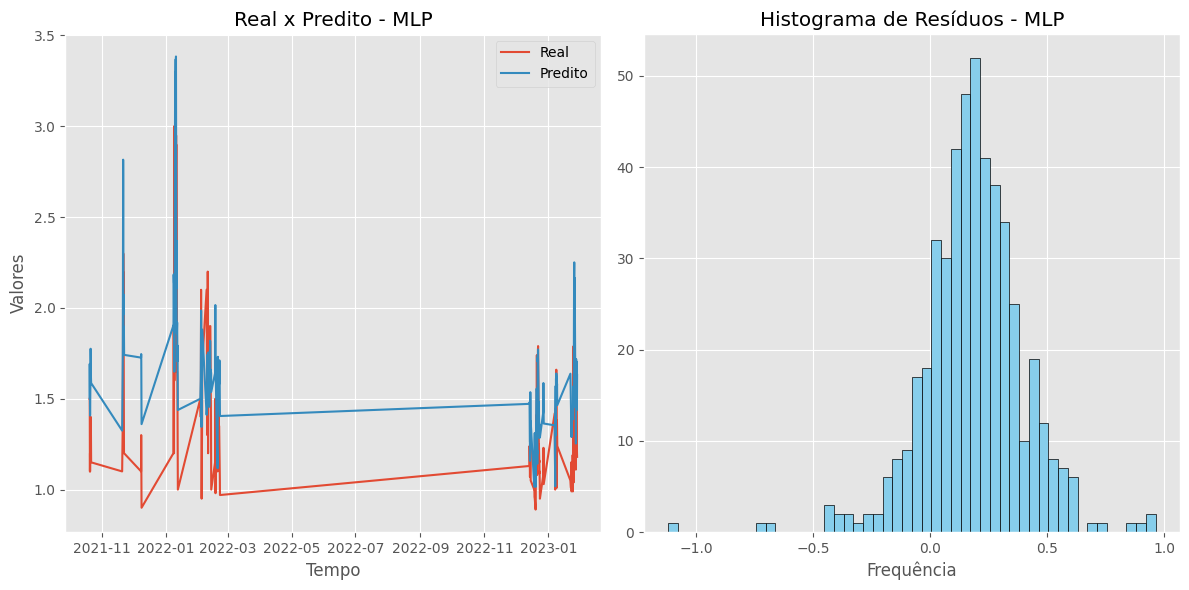

2023-09-12 18:22:39.972959


Duração: 0:15:39.660274
----------------------------------------
2023-09-12 18:22:39.973011


 ---- MLP sklearn -----
Epoca: 1
[10, 'tanh', 1e-06, 4, 0.1, 250]
RMSE: 0.30920 m^3/t
R2: 0.79804 m^3/t
[250, 'relu', 1e-07, 200, 0.001, 250]
RMSE: 0.24613 m^3/t
R2: 0.80135 m^3/t
[30, 'relu', 1e-07, 250, 0.1, 50]
RMSE: 0.24235 m^3/t
R2: 0.80727 m^3/t
[30, 'relu', 1e-07, 10, 0.001, 50]
RMSE: 0.23762 m^3/t
R2: 0.80351 m^3/t
[250, 'relu', 1e-06, 4, 0.001, 400]
RMSE: 0.22599 m^3/t
R2: 0.79807 m^3/t
----------------------------------------
Epoca: 2
----------------------------------------
Epoca: 3
----------------------------------------
Epoca: 4
----------------------------------------
Epoca: 5
----------------------------------------


Melhor Arquitetura: [250, 'relu', 1e-06, 4, 0.001, 400]
RMSE MLP p/ toda a base: 0.20000 m^3/t
R2 MLP p/ toda a base: 0.81838


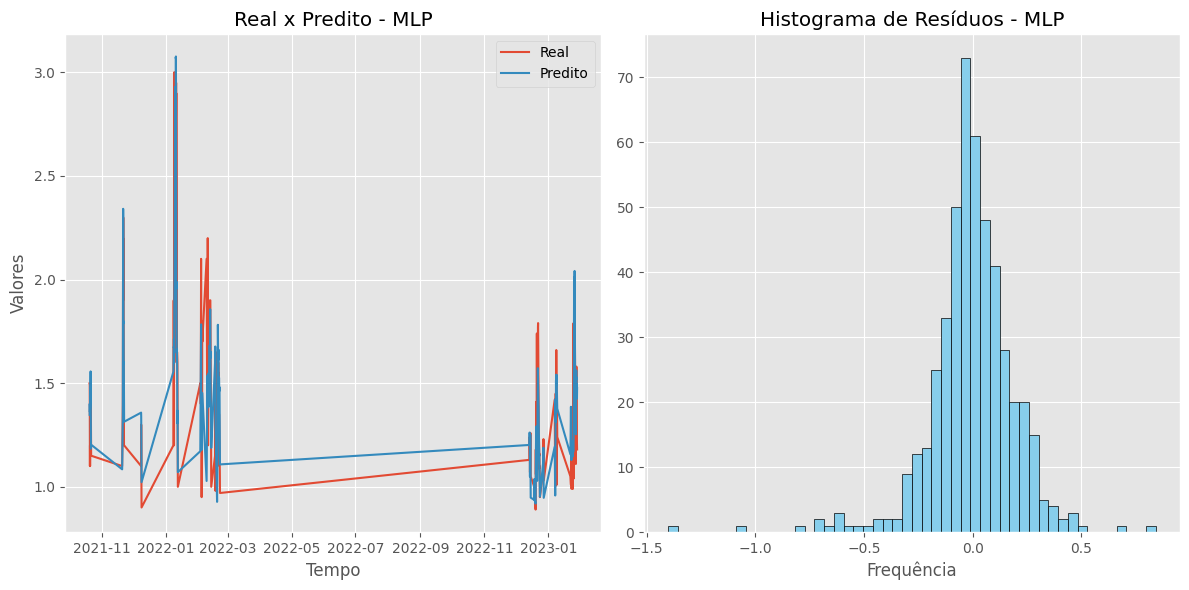

2023-09-12 18:34:04.775597


Duração: 0:11:24.802586
----------------------------------------
2023-09-12 18:34:04.775645


 ---- MLP sklearn -----
Epoca: 1
[250, 'tanh', 1e-06, 250, 0.1, 250]
RMSE: 0.27150 m^3/t
R2: 0.78869 m^3/t
[10, 'relu', 1e-06, 10, 0.001, 250]
RMSE: 0.23781 m^3/t
R2: 0.79825 m^3/t
[30, 'relu', 1e-07, 4, 0.001, 50]
RMSE: 0.23495 m^3/t
R2: 0.78991 m^3/t
[250, 'relu', 1e-06, 250, 0.1, 400]
RMSE: 0.22789 m^3/t
R2: 0.80129 m^3/t
----------------------------------------
Epoca: 2
----------------------------------------
Epoca: 3
[250, 'relu', 1e-07, 250, 0.1, 250]
RMSE: 0.22017 m^3/t
R2: 0.80412 m^3/t
----------------------------------------
Epoca: 4


: 

In [ ]:
for _ in range(5):
    start = datetime.datetime.now()
    print(start)
    print('\n')
    print(' ---- MLP sklearn -----')
    nas_teste.performance_estimation_strategy(300, epocas) 
    end = datetime.datetime.now()
    print(end, sep='\n')
    print('\n')
    print(f'Duração: {end - start}')
    print('-'* 40)
